In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from datetime import datetime

In [3]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [4]:
current_date = pd.to_datetime('2025-01-27')
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

merged = transactions.merge(products, on='ProductID', how='left')
merged = merged.merge(customers, on='CustomerID', how='left')

In [5]:
# Feature engineering
customer_features = merged.groupby('CustomerID').agg(
    Total_Transactions=('TransactionID', 'count'),
    Total_Spent=('TotalValue', 'sum'),
    Avg_Transaction_Value=('TotalValue', 'mean'),
    Unique_Products=('ProductID', 'nunique'),
    Favorite_Category=('Category', lambda x: x.mode()[0])
).reset_index()


In [6]:
# Calculate tenure in days
customers['Tenure'] = (current_date - customers['SignupDate']).dt.days


In [7]:
# Merge features
features = customers.merge(customer_features, on='CustomerID', how='left')

In [8]:
# Handle missing values
features.fillna({
    'Total_Transactions': 0,
    'Total_Spent': 0,
    'Avg_Transaction_Value': 0,
    'Unique_Products': 0,
    'Favorite_Category': 'None'
}, inplace=True)


In [9]:
# Preprocessing
features = pd.get_dummies(features, columns=['Region', 'Favorite_Category'])
numeric_cols = ['Tenure', 'Total_Transactions', 'Total_Spent', 'Avg_Transaction_Value', 'Unique_Products']
scaler = StandardScaler()
features[numeric_cols] = scaler.fit_transform(features[numeric_cols])


Optimal k: 2


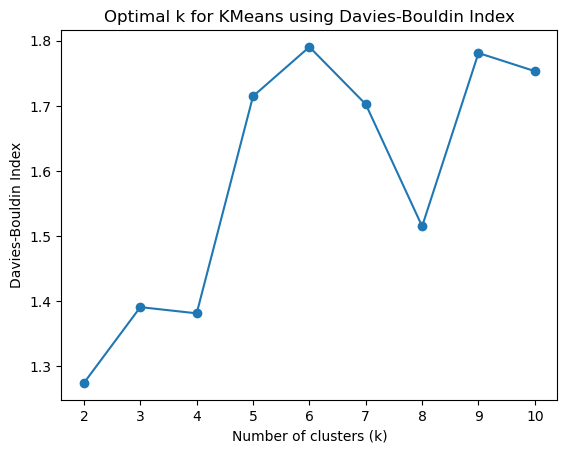

In [20]:
range_k = range(2, 11)
db_scores = []

# Select only numeric columns for clustering
numeric_features = features[numeric_cols + list(features.columns[8:])]

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(numeric_features)
    score = davies_bouldin_score(numeric_features, labels)
    db_scores.append(score)

# Find the optimal k
optimal_k = range_k[db_scores.index(min(db_scores))]
print(f'Optimal k: {optimal_k}')

# Plot the scores
plt.plot(range_k, db_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Optimal k for KMeans using Davies-Bouldin Index')
plt.show()

In [21]:
optimal_k

2

In [22]:
# Final clustering with optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
features['Cluster'] = final_kmeans.fit_predict(features[numeric_cols + list(features.columns[8:])])

In [23]:
# Visualization with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features[numeric_cols + list(features.columns[8:])])

Text(0, 0.5, 'PCA Component 2')

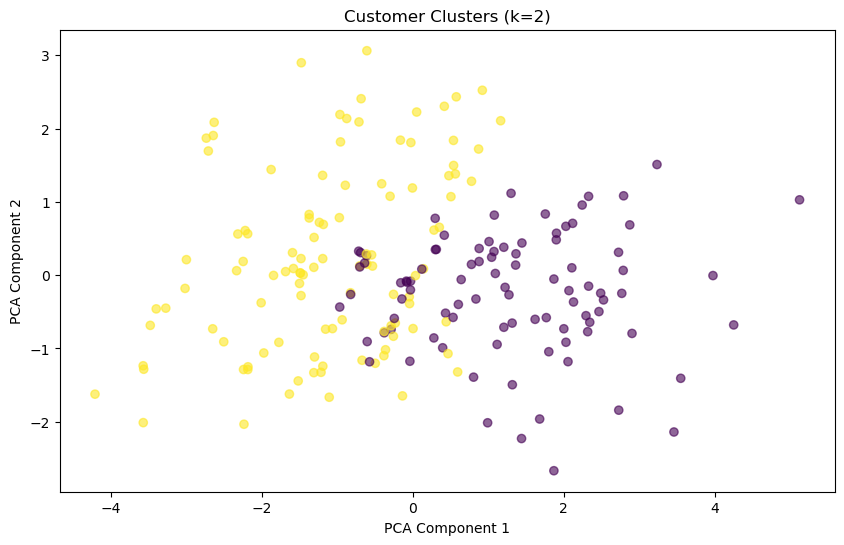

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=features['Cluster'], cmap='viridis', alpha=0.6)
plt.title(f'Customer Clusters (k={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')